## PREPROCESSING THE DATA

In [ ]:
!pip install kaggle
from google.colab import files

# Upload your Kaggle API key (kaggle.json)
files.upload()

# Move the key to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!kaggle datasets download -d kwullum/fatal-police-shootings-in-the-us


  0% 0.00/1.06M [00:00<?, ?B/s]
100% 1.06M/1.06M [00:00<00:00, 53.0MB/s]


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# print(check_output(["ls", "/kaggle/input"]).decode("utf8"))

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import os
print(os.listdir())


['.config', 'PercentOver25CompletedHighSchool.csv', 'MedianHouseholdIncome2015.csv', 'PercentagePeopleBelowPovertyLevel.csv', 'PoliceKillingsUS.csv', 'archive (3).zip', 'fatal-police-shootings-in-the-us.zip', 'ShareRaceByCity.csv', 'sample_data']


In [ ]:
df = pd.read_csv("./PoliceKillingsUS.csv", encoding="windows-1252")
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False



<h1> Information about the dataset

In [ ]:
def information(dataframe):
    print('Shape\n')
    print(pd.DataFrame({'Row Count': [dataframe.shape[0]],
                        'Column Count': [dataframe.shape[1]]
                       },index=['']
                      )
         )
    print('----------------------------------------------\n')
    print('General Info\n')
    print(dataframe.info())
    print('----------------------------------------------\n')
    print('Missing Values\n')
    print(dataframe.isna().sum())

information(df)

Shape

  Row Count  Column Count
       2340            13
----------------------------------------------

General Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2534
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   date                     2340 non-null   object
 1   armed                    2334 non-null   object
 2   age                      2340 non-null   int64 
 3   gender                   2340 non-null   object
 4   race                     2340 non-null   object
 5   City                     2340 non-null   object
 6   state                    2340 non-null   object
 7   signs_of_mental_illness  2340 non-null   bool  
 8   threat_level             2340 non-null   object
 9   flee                     2288 non-null   object
 10  body_camera              2340 non-null   bool  
 11  total_population         2340 non-null   object
 12  city                     

<h1> Categorical and Numerical Variables

In [ ]:
def col_summary(dataframe, cat_th=13, car_th=20):
    categorical_cols= [col for col in df.columns if str(df[col].dtypes) in ["category","object", "bool"]]
    numerical_but_categorical_cols=[col for col in df.columns if df[col].nunique()<10 and df[col].dtypes in ["int", "float"]]
    categorical_but_cardinal_cols= [col for col in df.columns if df[col].nunique()>20 and str(df[col].dtypes) in ["category", "object"]]
    categorical_cols= categorical_cols + numerical_but_categorical_cols
    categorical_cols = [col for col in categorical_cols if col not in categorical_but_cardinal_cols]

    numerical_cols= [col for col in df.columns if df[col].dtypes in ["int", "float"]]
    numerical_cols= [col for col in numerical_cols if col not in categorical_cols]


    print(f"Categorical_cols: {categorical_cols}")
    print(f"Numerical_cols: {numerical_cols}")
    print(f"Categorical_but_cardinal_cols: {categorical_but_cardinal_cols}")
    print(f"Numerical_but_categorical_cols: {numerical_but_categorical_cols}")

    return categorical_cols, numerical_cols,categorical_but_cardinal_cols, numerical_but_categorical_cols

categorical_cols, numerical_cols, categorical_but_cardinal_cols, numerical_but_categorical_cols= col_summary(df)

Categorical_cols: ['gender', 'race', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'total_population']
Numerical_cols: ['age']
Categorical_but_cardinal_cols: ['date', 'armed', 'City', 'state', 'city']
Numerical_but_categorical_cols: []


<h1> Data Cleaning

In [ ]:
# Fill null age values with mean
df.age.fillna(int(df.age.mean()), inplace=True)

# Fill null values with 'unknown'
def fill_null_values(dataframe, columns, default='unknown'):
    [dataframe[col].fillna(default, inplace=True) for col in columns]


fill_null_values(df, ['race', 'armed', 'flee'])

In [ ]:
# Let's check if there is any null value
df.isna().sum()

date                       0
armed                      0
age                        0
gender                     0
race                       0
City                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
total_population           0
city                       0
dtype: int64

In [ ]:
df = df.rename(columns={"city": "City"})

df.drop(["id", "name", "manner_of_death"], axis=1, inplace=True) # Deleting useless columns

df.age.fillna(value=df.age.mean(), inplace=True) # Dealing with missing AGE values. Set them to mean of all ages.
df.age = df.age.astype(int)

df.dropna(subset=["race"], inplace=True) # Deleting rows with missing values for race

df.drop(df.index[2363:], inplace=True) # Deleting deaths after 01/06/2017, as more info is missing about these, including vital information such as race

<br>
Adding a column to the dataset called "total population" with the total US population of the corresponding race.
Source: https://en.wikipedia.org/wiki/Demography_of_the_United_States
<br>

In [ ]:
# Adding total_population column with data corresponding to race

conditions = [df["race"]=="A", df["race"]=="W", df["race"]=="H", df["race"]=="B", df["race"]=="N", df["race"]=="O"]
numbers = [14674252, 223553265, 50477594, 38929319, 2932248, 22579629]

df["total_population"] = np.select(conditions, numbers, default="zero")

df.head()

,date,armed,age,gender,race,City,state,signs_of_mental_illness,threat_level,flee,body_camera,total_population
0,02/01/15,gun,53,M,A,Shelton,WA,True,attack,Not fleeing,False,14674252
1,02/01/15,gun,47,M,W,Aloha,OR,False,attack,Not fleeing,False,223553265
2,03/01/15,unarmed,23,M,H,Wichita,KS,False,other,Not fleeing,False,50477594
3,04/01/15,toy weapon,32,M,W,San Francisco,CA,True,attack,Not fleeing,False,223553265
4,04/01/15,nail gun,39,M,H,Evans,CO,False,attack,Not fleeing,False,50477594


## EXPLORATORY ANALYSIS

#### Total number of people killed, by race

Text(0.5, 1.0, 'Total number of people killed, by race')

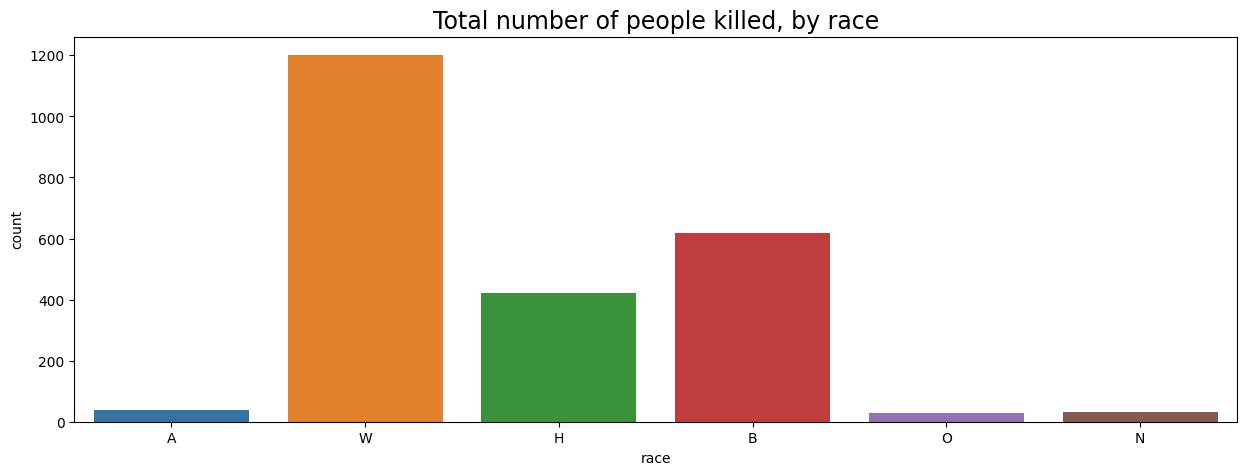

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x="race")

plt.title("Total number of people killed, by race", fontsize=17)

The dataset divides race into Asian, White, Hispanic, Black, Native American and Other. From the bar chart we can see that the overwhelming majority being killed by police is either White, Hispanic or Black, with White being the race with the largest amount of victims.
This makes sense since White is the largest racial group in the US, followed by Black and Hispanic.

#### Number of people killed as a proportion of respective races

In [ ]:
# List of nr of people killed per race

races = ["A", "W", "H", "B", "N", "O"]
killed_per_race = []

for i in races:
    i_killings = df.race.loc[(df.race==i)].count()
    killed_per_race.append(i_killings)

print (killed_per_race)

[39, 1201, 423, 618, 31, 28]


In [ ]:
prop_killed_per_race = []

for i in races:

    if i == "A":
        prop_i_killed = killed_per_race[0]/14674252.0
        print (prop_i_killed)
    elif i == "W":
        prop_i_killed = killed_per_race[1]/223553265.0
        print (prop_i_killed)
    elif i == "H":
        prop_i_killed = killed_per_race[2]/50477594.0
        print (prop_i_killed)
    elif i == "B":
        prop_i_killed = killed_per_race[3]/38929319.0
        print (prop_i_killed)
    elif i == "N":
        prop_i_killed = killed_per_race[4]/2932248.0
        print (prop_i_killed)
    else:
        prop_i_killed = killed_per_race[5]/22579629.0
        print (prop_i_killed)

    prop_killed_per_race.append(prop_i_killed)

2.6577163864979287e-06
5.3723214465241655e-06
8.379955669043972e-06
1.5874924500991144e-05
1.0572093492774145e-05
1.240055804282701e-06


<Axes: title={'center': 'People killed as a proportion of their respective race'}>

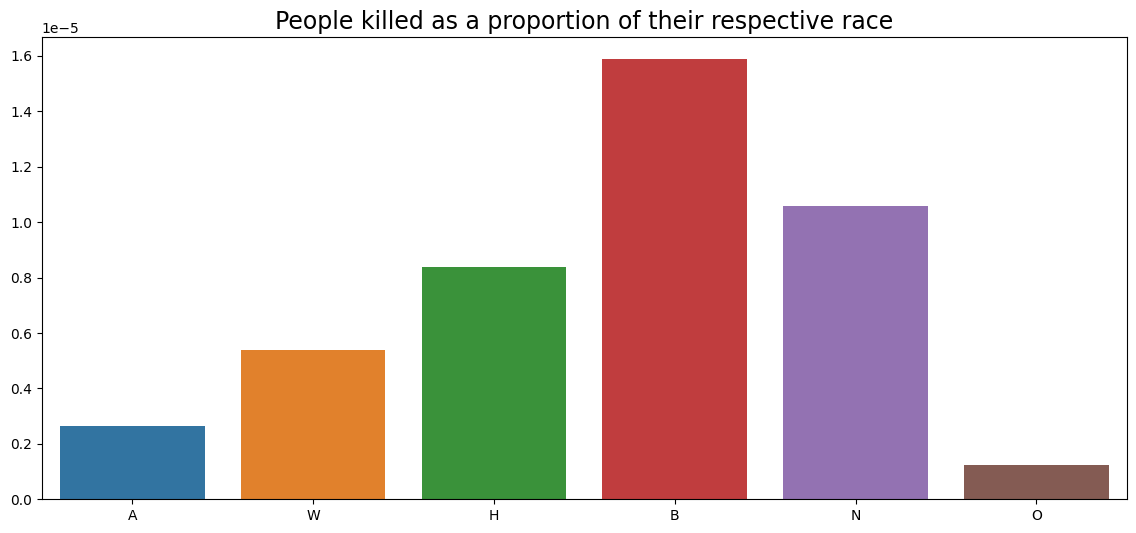

In [ ]:
plt.figure(figsize=(14,6))
plt.title("People killed as a proportion of their respective race", fontsize=17)
sns.barplot(x=races, y=prop_killed_per_race)

This bar chart shows the number of victims per race as a proportion of the total US population of respective race.
Earlier, when we looked at the total number of people killed, we saw that twice as many Whites were killed as Blacks. However, if you look at the numbers as the proportion of the racial population, Blacks are approximately 3 times as likely to be killed by police than Whites.

#### Total number of people killed, by gender

95.8119658119658% of the victims are male.


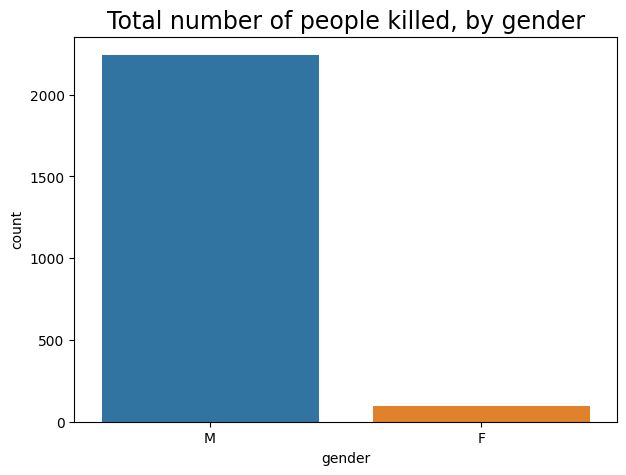

In [ ]:
female = df[df["gender"] == "F"].gender.count()
male = df[df["gender"] == "M"].gender.count()
perc_male = (male*100)/(male+female)

plt.figure(figsize=(7,5))
sns.countplot(data=df, x="gender")

plt.title("Total number of people killed, by gender", fontsize=17)

print (str(perc_male) + "% " + "of the victims are male.")

#### General age distribution

<ipython-input-19-3fe8c462a58d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  age_dist = sns.distplot(df["age"], bins=40)


Text(0.5, 1.0, 'Age distribution')

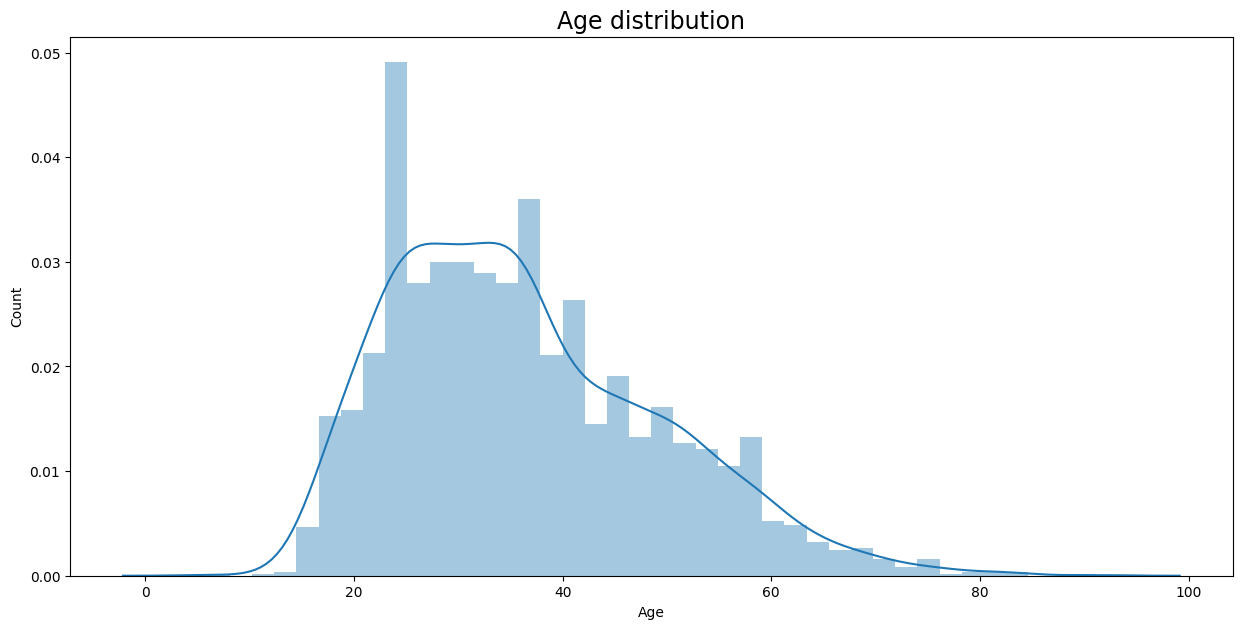

In [ ]:
plt.figure(figsize=(15,7))
age_dist = sns.distplot(df["age"], bins=40)
age_dist.set(xlabel="Age", ylabel="Count")

plt.title("Age distribution", fontsize=17)

#### Comparing age distributions of Blacks, Whites, and Hispanics

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


Text(0.5, 1.0, 'Age distribution, by race')

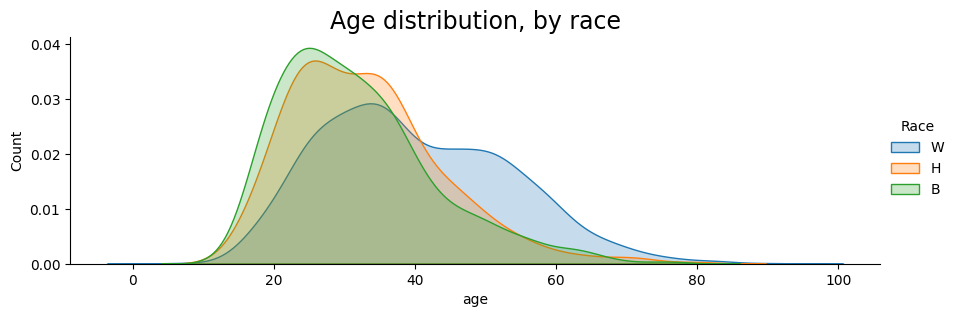

In [ ]:
# First, create dataset with only Blacks, Whites, Hispanics

three_races = df.loc[(df["race"] == "B") | (df["race"] == "W") | (df["race"] == "H")]

g = sns.FacetGrid(data=three_races, hue="race", aspect=3)
g.map(sns.kdeplot, "age", shade=True)
g.add_legend(title="Race")


g.set_ylabels("Count")
plt.title("Age distribution, by race", fontsize=17)

The age distribution of Blacks and Hispanics is skewed to the left, whereas the age distribution for Whites is more spread out. On average, Blacks and Hispanics are being killed at a younger age than Whites - which is consistent with the initial hypothesis that black males are subject to police killings at a young age.

In [ ]:
avg_age_w = df.age[(df["race"] == "W")].mean()
avg_age_b = df.age[(df["race"] == "B")].mean()
avg_age_h = df.age[(df["race"] == "H")].mean()

print ("Average age of white victims is " + str(avg_age_w))
print ("Average age of black victims is " + str(avg_age_b))
print ("Average age of hispanic victims is " + str(avg_age_h))

Average age of white victims is 40.01665278934222
Average age of black victims is 31.699029126213592
Average age of hispanic victims is 33.0661938534279


#### Number of fatal shootings in each state

Text(0.5, 1.0, 'Number of police killings, by state')

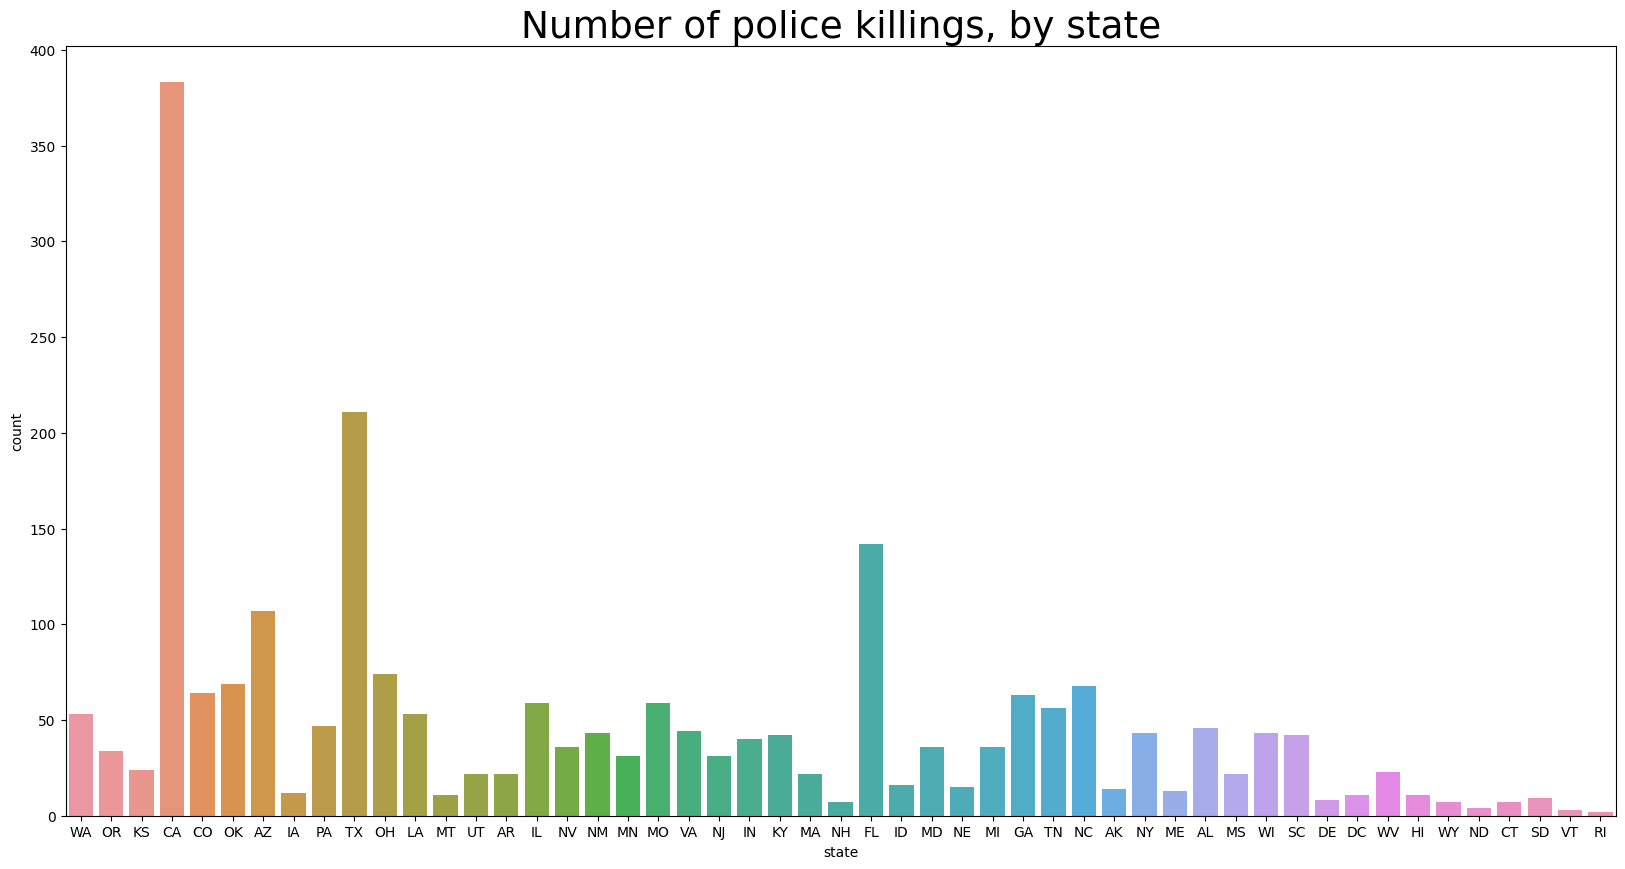

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(data=df, x=df.state)
plt.title("Number of police killings, by state", fontsize=27)

California, Texas and Florida are the states in which police killings are most frequent. These are also the three most populous states in the US.

#### Most dangerous cities

Text(0.5, 1.0, 'Most dangerous cities')

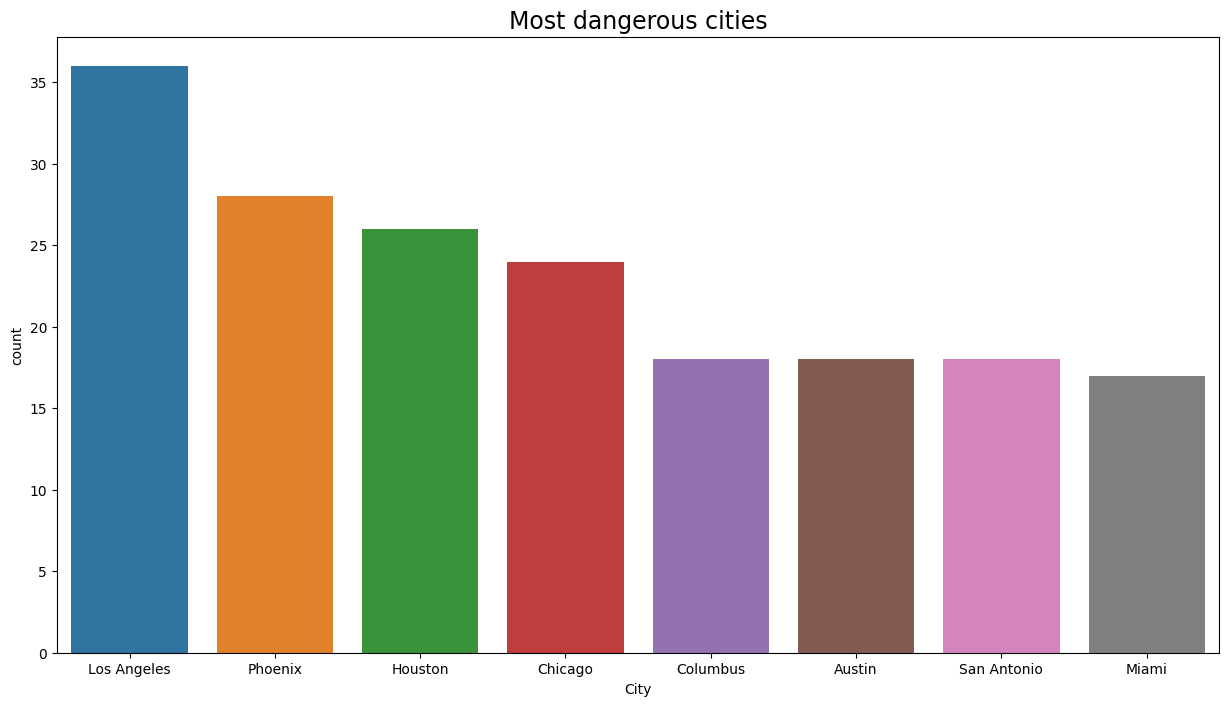

In [ ]:
city = df.City.value_counts(ascending=False)

df_city = df.filter(["City"], axis=1)
df_city["count"] = 1

grouped_city = df_city.groupby("City", as_index=False,sort=False).sum()
grouped_city.sort_index(ascending=False)

grouped_city = grouped_city.sort_values("count", ascending=False).head(8)

plt.figure(figsize=(15,8))
sns.barplot(data=grouped_city, x="City", y="count")
plt.title("Most dangerous cities", fontsize=17)

#### Visualizing police shootings using Tableau

In [ ]:
%%HTML
<div class='tableauPlaceholder' id='viz1504205405904' style='position: relative'>
  <noscript>
    <a href='#'>
      <img alt='Sheet 1' src='https://public.tableau.com/static/images/In/InteractivePoliceKillingsMap/Sheet1/1_rss.png' style='border: none' />
    </a>
  </noscript>
  <object class='tableauViz' style='display:none;'>
    <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' />
    <param name='path' value='views%2FInteractivePoliceKillingsMap%2FSheet1?:embed=y&amp;:display_count=y&amp;publish=yes' />
    <param name='toolbar' value='yes' />
    <param name='static_image' value='https://public.tableau.com/static/images/In/InteractivePoliceKillingsMap/Sheet1/1.png' />
    <param name='animate_transition' value='yes' />
    <param name='display_static_image' value='yes' />
    <param name='display_spinner' value='yes' />
    <param name='display_overlay' value='yes' />
    <param name='display_count' value='yes' />
    <param name='filter' value='publish=yes' />
  </object>
</div>
<script type='text/javascript'>
  var divElement = document.getElementById('viz1504205405904');
  var vizElement = divElement.getElementsByTagName('object')[0];
  vizElement.style.width = '100%';
  vizElement.style.height = (divElement.offsetWidth * 0.75) + 'px';
  var scriptElement = document.createElement('script');
  scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';
  vizElement.parentNode.insertBefore(scriptElement, vizElement);
</script>


#### Most common ways of being armed

Text(0.5, 1.0, 'Most common ways of being armed')

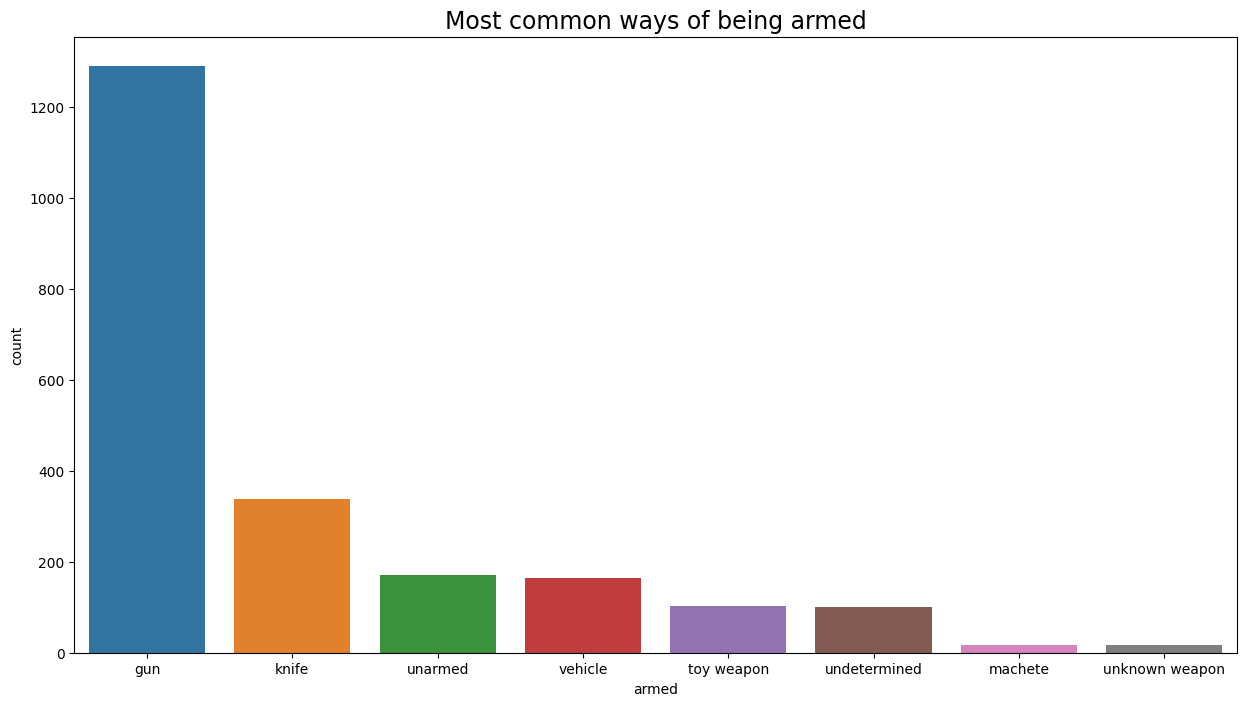

In [ ]:
armed = df.armed.value_counts(ascending=False)

df_armed = df.filter(["armed"], axis=1)
df_armed["count"] = 1

grouped_armed = df_armed.groupby("armed", as_index=False,sort=False).sum()
grouped_armed.sort_index(ascending=False)

grouped_armed = grouped_armed.sort_values("count", ascending=False).head(8)

plt.figure(figsize=(15,8))
sns.barplot(data=grouped_armed, x="armed", y="count")
plt.title("Most common ways of being armed", fontsize=17)

## Adding features (census data)
<br>
Using US census data, I have compiled datasets on median household income, poverty rate, high school graduation rate, and the racial demographic in each city. This information is then added to the original dataset. Below I merge these datasets, and apply various machine learning algorithms to explore whether it's possible to predict the race of a victim based on the features.

#### Preprocessing the census data

In [ ]:
income = pd.read_csv("./MedianHouseholdIncome2015.csv", encoding="windows-1252")
income["City"].replace(["city", "CDP", "town"], "", regex=True, inplace=True)
income["city"] = income["City"] + ", " + income["Geographic Area"]
income.drop(["Geographic Area", "City"], axis=1, inplace=True)

poverty = pd.read_csv("./PercentagePeopleBelowPovertyLevel.csv", encoding="windows-1252")
poverty["City"].replace(["city", "CDP", "town"], "", regex=True, inplace=True)
poverty["city"] = poverty["City"] + ", " + poverty["Geographic Area"]
poverty.drop(["Geographic Area", "City"], axis=1, inplace=True)

race = pd.read_csv("./ShareRaceByCity.csv", encoding="windows-1252")
race["City"].replace(["city", "CDP", "town"], "", regex=True, inplace=True)
race["city"] = race["City"] + ", " + race["Geographic area"]
race.drop(["Geographic area", "City"], axis=1, inplace=True)

highschool = pd.read_csv("./PercentOver25CompletedHighSchool.csv", encoding="windows-1252")
highschool["City"].replace(["city", "CDP", "town"], "", regex=True, inplace=True)
highschool["city"] = highschool["City"] + ", " + highschool["Geographic Area"]
highschool.drop(["Geographic Area", "City"], axis=1, inplace=True)

#### Merging the datasets

In [ ]:
df["city"] = df["City"] + " , " + df["state"] # Creating the same "city" format
merge1 = pd.merge(poverty, race, on="city", how="outer")
merge2 = pd.merge(merge1, income, on="city", how="outer")
merge3 = pd.merge(merge2, highschool, on="city", how="outer")
data = pd.merge(df, merge3, on="city", how="outer")
data.dropna(inplace=True)

data[["Median Income", "poverty_rate", "share_white", "share_black", "share_native_american", "share_asian",
      "share_hispanic", "percent_completed_hs"]] = data[["Median Income", "poverty_rate", "share_white", "share_black", "share_native_american", "share_asian",
      "share_hispanic", "percent_completed_hs"]].replace("(X)", np.NaN)
data[["Median Income", "poverty_rate", "share_white", "share_black", "share_native_american", "share_asian",
      "share_hispanic", "percent_completed_hs"]] = data[["Median Income", "poverty_rate", "share_white", "share_black", "share_native_american", "share_asian",
      "share_hispanic", "percent_completed_hs"]].replace("-", np.NaN)

data[["Median Income", "poverty_rate", "share_white", "share_black", "share_native_american", "share_asian",
      "share_hispanic", "percent_completed_hs"]] = data[["Median Income", "poverty_rate", "share_white", "share_black", "share_native_american", "share_asian",
      "share_hispanic", "percent_completed_hs"]].astype(float)

In [ ]:
data.dropna(inplace=True)

In [ ]:
# Converting neccesary columns to floats
data["poverty_rate"] = data["poverty_rate"].astype(float)
data["share_white"] = data["share_white"].astype(float)
data["share_black"] = data["share_black"].astype(float)
data["share_native_american"] = data["share_native_american"].astype(float)
data["share_asian"] = data["share_asian"].astype(float)
data["share_hispanic"] = data["share_hispanic"].astype(float)
data["percent_completed_hs"] = data["percent_completed_hs"].astype(float)
data["Median Income"] = data["Median Income"].astype(int)

In [ ]:
data.head()

,date,armed,age,gender,race,City,state,signs_of_mental_illness,threat_level,flee,...,total_population,city,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic,Median Income,percent_completed_hs
0,02/01/15,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,...,14674252,"Shelton , WA",28.6,78.9,0.8,3.7,1.1,19.2,37072,80.1
1,02/01/15,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,...,223553265,"Aloha , OR",14.9,70.9,2.6,1.0,8.9,21.1,65765,88.1
2,02/10/15,knife,55.0,F,W,Aloha,OR,True,other,Not fleeing,...,223553265,"Aloha , OR",14.9,70.9,2.6,1.0,8.9,21.1,65765,88.1
3,03/01/15,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,...,50477594,"Wichita , KS",17.3,71.9,11.5,1.2,4.8,15.3,45947,87.5
4,22/08/15,vehicle,26.0,M,W,Wichita,KS,False,attack,Car,...,223553265,"Wichita , KS",17.3,71.9,11.5,1.2,4.8,15.3,45947,87.5


## RANDOM FOREST ALGORITHM TO PREDICT RACE

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Mapping True/False to 1/0

data["signs_of_mental_illness"] = data["signs_of_mental_illness"].astype(int)
data["body_camera"] = df["body_camera"].astype(int)

# Using LabelEncoder to deal with categorical features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(["armed", "race", "gender", "city", "state", "threat_level", "flee"])

LabelEncoder()

In [ ]:
data_log = data.apply(LabelEncoder().fit_transform)

X = data_log
y = data_log["race"]
X.drop(["race", "date", "total_population"], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
rfc_pred = rfc.predict(X_test)
rfc.feature_importances_

array([0.04922817, 0.13500872, 0.00603731, 0.04117866, 0.04175947,
       0.02475221, 0.02616833, 0.03222647, 0.01387798, 0.04357904,
       0.04703269, 0.11718917, 0.11243937, 0.05004176, 0.05312523,
       0.10287519, 0.04550656, 0.05797368])

In [ ]:
feature_data = pd.DataFrame({"feature_name": data_log.columns, "feature_importance": rfc.feature_importances_})
feature_data

,feature_name,feature_importance
0,armed,0.049228
1,age,0.135009
2,gender,0.006037
3,City,0.041179
4,state,0.041759
5,signs_of_mental_illness,0.024752
6,threat_level,0.026168
7,flee,0.032226
8,body_camera,0.013878
9,city,0.043579


The most important features in predicting race using the Random Forest algorithm are age and racial demographics.

In [ ]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.62      0.58      0.60       153
           2       0.62      0.50      0.56       127
           3       0.50      0.29      0.36         7
           4       0.44      0.50      0.47         8
           5       0.71      0.81      0.75       309

    accuracy                           0.67       616
   macro avg       0.54      0.46      0.48       616
weighted avg       0.65      0.67      0.66       616



In [ ]:
from sklearn.metrics import accuracy_score

# Accuracy score
rf_accuracy_score = accuracy_score(y_test, rfc_pred)
rf_accuracy_score

0.6655844155844156

In [ ]:
params = {"max_depth": [32,44,50],
         "n_estimators": [15,18,26,32],
          "min_samples_leaf": [40,50,60],
         "criterion": ["gini", "entropy"]}

from sklearn import model_selection

gs_rf = model_selection.GridSearchCV(estimator=rfc,
                                 param_grid=params,
                                 cv=5,
                                 scoring="accuracy")

gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [32, 44, 50],
                         'min_samples_leaf': [40, 50, 60],
                         'n_estimators': [15, 18, 26, 32]},
             scoring='accuracy')

In [ ]:
# Extract the best parameters
gs_rf.best_params_

{'criterion': 'gini',
 'max_depth': 44,
 'min_samples_leaf': 40,
 'n_estimators': 15}

In [ ]:
# Accuracy score after grid search
gs_rf_accuracy_score = gs_rf.best_score_
gs_rf_accuracy_score

0.6576679248935348

<br>
## LOGISTIC REGRESSION ALGORITHM TO PREDICT RACE

In [ ]:
# Transforming columns into dummy varaibles

dummies = pd.get_dummies(data[["armed", "gender", "city", "City", "state", "threat_level", "flee","signs_of_mental_illness", "body_camera"]], drop_first=True)
dummies = pd.concat([data, dummies], axis=1)

dummies.drop(data[["date", "armed", "gender", "city", "City", "state", "threat_level", "flee", "total_population","signs_of_mental_illness", "body_camera"]], axis=1, inplace=True)
dummies.dropna()
dummies.head()

,age,race,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic,Median Income,percent_completed_hs,...,state_VT,state_WA,state_WI,state_WV,state_WY,threat_level_other,threat_level_undetermined,flee_Foot,flee_Not fleeing,flee_Other
0,53.0,A,28.6,78.9,0.8,3.7,1.1,19.2,37072,80.1,...,0,1,0,0,0,0,0,0,1,0
1,47.0,W,14.9,70.9,2.6,1.0,8.9,21.1,65765,88.1,...,0,0,0,0,0,0,0,0,1,0
2,55.0,W,14.9,70.9,2.6,1.0,8.9,21.1,65765,88.1,...,0,0,0,0,0,1,0,0,1,0
3,23.0,H,17.3,71.9,11.5,1.2,4.8,15.3,45947,87.5,...,0,0,0,0,0,1,0,0,1,0
4,26.0,W,17.3,71.9,11.5,1.2,4.8,15.3,45947,87.5,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = dummies.drop("race", axis=1)
y = dummies["race"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [ ]:
predictions = logmodel.predict(X_test)
print (classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        12
           B       0.64      0.54      0.58       153
           H       0.58      0.54      0.56       127
           N       0.00      0.00      0.00         7
           O       0.00      0.00      0.00         8
           W       0.69      0.82      0.75       309

    accuracy                           0.66       616
   macro avg       0.32      0.32      0.32       616
weighted avg       0.62      0.66      0.64       616



In [ ]:
# Accuracy score
log_accuracy_score = accuracy_score(y_test, predictions)
log_accuracy_score

0.6574675324675324

In [ ]:
params = {"max_iter": [20,30,50],
         "C": [1.0, 2.0, 3.0]}

gs_logmodel = model_selection.GridSearchCV(estimator=logmodel,
                                 param_grid=params,
                                 cv=5,
                                 scoring="accuracy")

gs_logmodel.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1.0, 2.0, 3.0], 'max_iter': [20, 30, 50]},
             scoring='accuracy')

In [ ]:
gs_logmodel.best_params_

{'C': 1.0, 'max_iter': 50}

In [ ]:
# Accuracy score
gs_logmodel_accuracy_score = gs_logmodel.best_score_
gs_logmodel_accuracy_score

0.6040771389856755

<br>
## KNN ALGORITHM

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X = dummies.drop("race", axis=1)
y = dummies["race"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

knn = KNeighborsClassifier(n_neighbors=1) # k=1
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
pred = knn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        12
           B       0.46      0.50      0.47       153
           H       0.46      0.35      0.40       127
           N       0.17      0.29      0.21         7
           O       0.25      0.38      0.30         8
           W       0.64      0.66      0.65       309

    accuracy                           0.54       616
   macro avg       0.33      0.36      0.34       616
weighted avg       0.53      0.54      0.53       616



In [ ]:
knn_accuracy_score = accuracy_score(y_test, pred)
knn_accuracy_score

0.5357142857142857

In [ ]:
error_rate = []

for i in range(1,30): # Checking every possible k value from 1-30

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error rate')

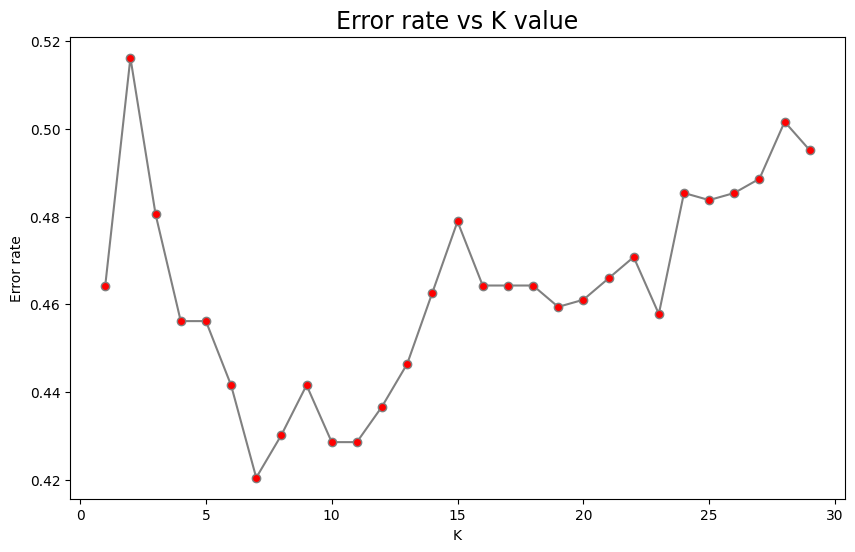

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30), error_rate, color="grey", marker="o", markerfacecolor="red")
plt.title("Error rate vs K value", fontsize=17)
plt.xlabel("K")
plt.ylabel("Error rate")

k=7 gives the lowest error rate, so we try fitting the model again, using this information.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        12
           B       0.52      0.54      0.53       153
           H       0.48      0.36      0.41       127
           N       0.00      0.00      0.00         7
           O       0.00      0.00      0.00         8
           W       0.64      0.74      0.68       309

    accuracy                           0.58       616
   macro avg       0.27      0.27      0.27       616
weighted avg       0.55      0.58      0.56       616



In [ ]:
# Accuracy score
knn_accuracy_score_iter = accuracy_score(y_test, pred)
knn_accuracy_score_iter

0.5795454545454546

## Comparing accuracy scores

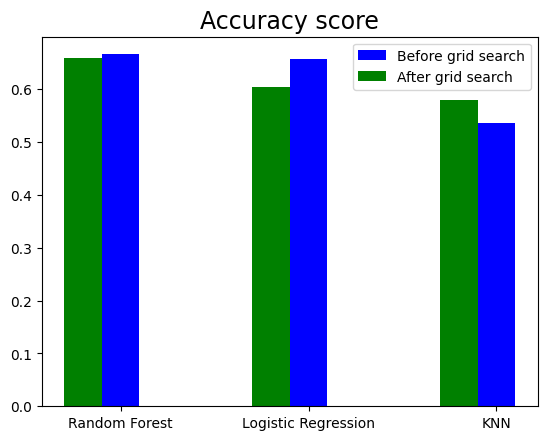

In [ ]:
accuracy_pre = {"Random Forest": rf_accuracy_score,
                "Logistic Regression": log_accuracy_score,
                "KNN": knn_accuracy_score}

accuracy_post = {"Random Forest": gs_rf_accuracy_score,
                 "Logistic Regression": gs_logmodel_accuracy_score,
                 "KNN": knn_accuracy_score_iter}

X = np.arange(len(accuracy_pre))
ax = plt.subplot(111)
ax.bar(X, accuracy_pre.values(), width=0.2, color='b', align='center')
ax.bar(X-0.2, accuracy_post.values(), width=0.2, color='g', align='center')
ax.legend(('Before grid search','After grid search'))
plt.xticks(X, accuracy_pre.keys())
plt.title("Accuracy score", fontsize=17)
plt.show()

Logistic Regression and the Random Forest algorithms yield the highest accuracy score both before and after running grid search. The KNN algorithm performs better after grid search, whereas Logistic Regression and Random Forest don't.
KNN doesn't do much better than random choice, meaning there is a risk that there simply is no connection between features and the target class.

Now, we explore the US Police Shootings dataset, which has data on fatal shootings by on-duty police officers in the US between January 2015 and May 2020. Using this dataset we will explore several important questions which can be found below. For each question we will attempt to create at least one visualisation which helps to understand the data behind the answers by using the packages seaborn and plotly.

1. [Who Are The Police Killing?](#Who-Are-The-Police-Killing?)
2. [Are African-Americans Disproportionately Killed?](#Are-African-Americans-Disproportionately-Killed?)
3. [Where Do Shootings Happen?](#Where-Do-Shootings-Happen?)
4. [Are Police Shooting Deaths Increasing?](#Are-Police-Shooting-Deaths-Increasing?)
5. [Are Victims Armed or Unarmed?](#Are-Victims-Armed-or-Unarmed?)
6. [Who Are The Unarmed Victims?](#Who-Are-The-Unarmed-Victims?)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.graph_objects as go

We also need to import our data. This can be seen below.

In [ ]:
data = pd.read_csv('./fatal-police-shootings-data.csv')
data.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


# Who Are The Police Killing?
Firstly, we will use seaborn to create a few bar plots about data relating to victims of police shootings. We can see that an overwhelming majority of victims are male. We can also see that many victims are white, but this does not take into account the demographics of USA (this data is not available in this dataset, we would need to import more data). We can also see that age is widely distributed across the population with that plot peaking at ages 15 to 25. Again, this does not take into account the demographics of USA.

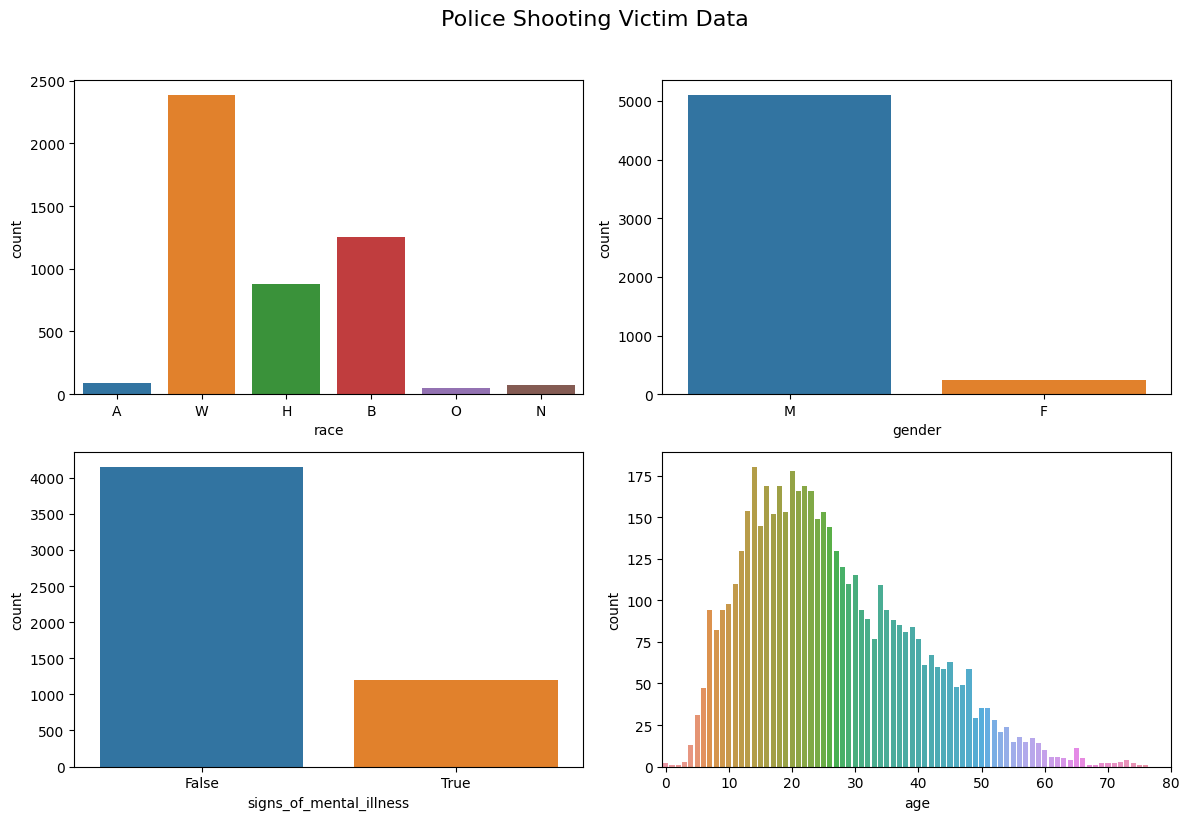

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

sns.countplot(x='race', orient='v', ax=ax1, data=data)
sns.countplot(x='gender', orient='v', ax=ax2, data=data)
sns.countplot(x='signs_of_mental_illness', orient='v', ax=ax3, data=data)
sns.countplot(x='age', orient='v', ax=ax4, data=data)
ax4.set_xticks(range(0, 90, 10))
ax4.set_xticklabels(range(0, 90, 10))
fig.suptitle('Police Shooting Victim Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Are African-Americans Disproportionately Killed?
One socially important piece of information is whether certain races are being disproportionately killed by police shootings. We will investigate this by creating a bar plot with seaborn of the proportion of deaths and total population by race. We will then customise this plot further using matplotlib. We will also need to import another dataset where we can get the proportion of different races in the US population.

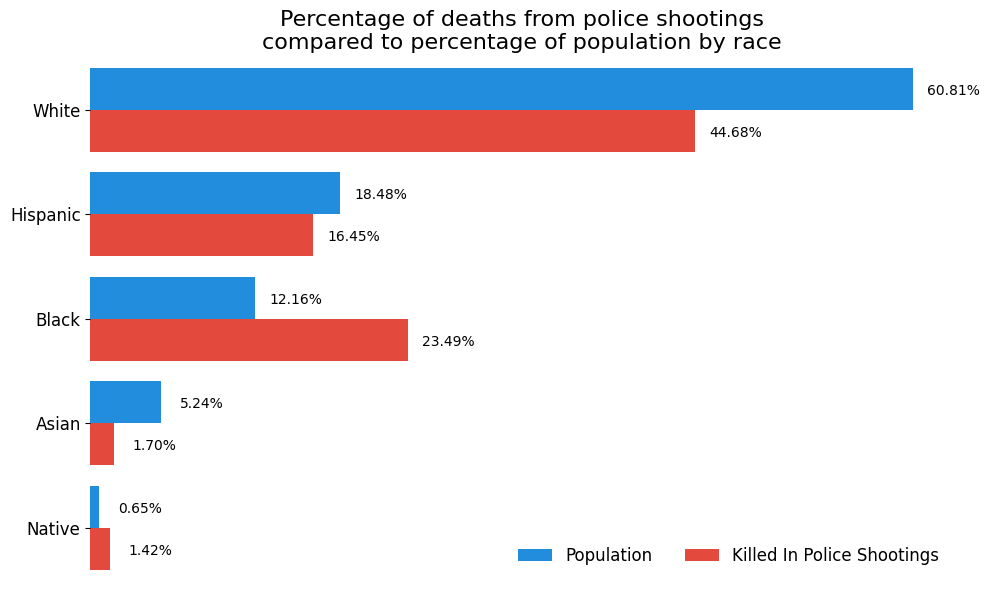

In [ ]:
# Get data
us_census_data = pd.read_csv('./acs2017_county_data.csv')

# Get population proportions
total_population = us_census_data['TotalPop'].sum()
race_proportions = pd.DataFrame(['White', 'Hispanic', 'Black', 'Asian', 'Native'], columns=['Race'])
race_proportions['Population'] = race_proportions['Race'].apply(lambda x: us_census_data.apply(lambda y: y['TotalPop'] * y[x] / total_population, axis=1).sum())
race_proportions['Killed In Police Shootings'] = race_proportions['Race'].apply(lambda x: data[data['race'] == x[0]].shape[0] * 100 / data.shape[0])

# Plot proportions
race_proportions = race_proportions.melt(id_vars='Race')
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.barplot(x='value', y='Race', hue='variable',data=race_proportions, ax=ax,
            orient='h', palette=['#0390fc', '#ff3321'])

# Annotate with values
for p in ax.patches:
    width = p.get_width()
    plt.text(3+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}%'.format(width),
             ha='center', va='center')

# Customise and show
ax.set_title('Percentage of deaths from police shootings\ncompared to percentage of population by race', fontsize=16)
ax.tick_params(axis='both', labelsize=12)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
plt.legend(frameon=False, fontsize=12, ncol=2)
plt.tight_layout()
plt.show()

From this plot we can see that both black people and native people are disproportionately killed by the police. We can also see that for asians and white people, the percentages are far below that of their overall percentages of the population is the US.

# Where Do Shootings Happen?

We will now use plotly to create a choropleth map of the number of shootings in each US state. From our map below we can see that the states with the most shootings are California, Texas, and Florida. States near to Texas (such as Oklahoma) and Florida (such as Georgia) also have a higher number of shootings than other US states.

In [ ]:
state_counts = data.groupby(by='state').agg({'id' : 'count'}).reset_index()

fig = go.Figure(data=go.Choropleth(
    locations=state_counts['state'],
    z = state_counts['id'],
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Deaths"
))

fig.update_layout(
    title_text = 'Police Shooting Deaths by US States',
    geo_scope='usa'
)

fig.show()

Our first choropleth map does not take into consideration the population of each state - we would expect states with a higher population to have a higher number of deaths via police shootings. Therefore we will be importing [a dataset of US state populations from 2018](https://www.kaggle.com/lucasvictor/us-state-populations-2018), and then factoring that into our choropleth. You will see that our new map looks quite different.

In [ ]:
state_pops = pd.read_csv('./State Populations.csv')
state_codes = {'California' : 'CA', 'Texas' : 'TX', 'Florida' : 'FL', 'New York' : 'NY', 'Pennsylvania' : 'PA',
       'Illinois' : 'IL', 'Ohio' : 'OH', 'Georgia' : 'GA', 'North Carolina' : 'NC', 'Michigan' : 'MI',
       'New Jersey' : 'NJ', 'Virginia' : 'VA', 'Washington' : 'WA', 'Arizona' : 'AZ', 'Massachusetts' : 'MA',
       'Tennessee' : 'TN', 'Indiana' : 'IN', 'Missouri' : 'MO', 'Maryland' : 'MD', 'Wisconsin' : 'WI',
       'Colorado' : 'CO', 'Minnesota' : 'MN', 'South Carolina' : 'SC', 'Alabama' : 'AL', 'Louisiana' : 'LA',
       'Kentucky' : 'KY', 'Oregon' : 'OR', 'Oklahoma' : 'OK', 'Connecticut' : 'CT', 'Iowa' : 'IA', 'Utah' : 'UT',
       'Nevada' : 'NV', 'Arkansas' : 'AR', 'Mississippi' : 'MS', 'Kansas' : 'KS', 'New Mexico' : 'NM',
       'Nebraska' : 'NE', 'West Virginia' : 'WV', 'Idaho' : 'ID', 'Hawaii' : 'HI', 'New Hampshire' : 'NH',
       'Maine' : 'ME', 'Montana' : 'MT', 'Rhode Island' : 'RI', 'Delaware' : 'DE', 'South Dakota' : 'SD',
       'North Dakota' : 'ND', 'Alaska' : 'AK', 'District of Columbia' : 'DC', 'Vermont' : 'VT',
       'Wyoming' : 'WY'}
state_pops['State Codes'] = state_pops['State'].apply(lambda x: state_codes[x])
state_counts['Pop'] = state_counts['state'].apply(lambda x: state_pops[state_pops['State Codes'] == x].reset_index()['2018 Population'][0])

fig = go.Figure(data=go.Choropleth(
    locations=state_counts['state'],
    z = state_counts['id'] / state_counts['Pop'] * 100000,
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Deaths Per 100,000"
))

fig.update_layout(
    title_text = 'Police Shooting Deaths by US States per 100,000 People',
    geo_scope='usa'
)

fig.show()

We can see that when population is taken into account, the states with the most deaths via police shootings are New Mexico and Alaska. Many of the states which appeared high on the previous map appear lower on this map, however Oklahoma and Arizona still appear quite high.

# Are Police Shooting Deaths Increasing?
Now we will have a look at whether police shooting deaths are become more or less frequent. To do this, we will be using seaborn again, but this time we will be using a regplot. From regplot we will get a regression line through our data. We will need to group our data to do this, we will be grouping it into months in this example. From our final plot we can see that there is no major change in the number of shootings per month.

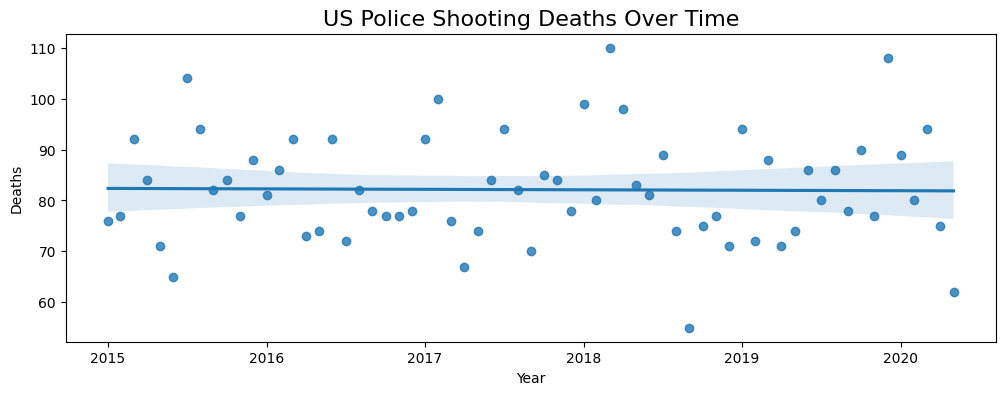

In [ ]:
from datetime import date

# Get date month data
data['date'] = pd.to_datetime(data['date'])
newd = data.groupby(pd.Grouper(key='date', freq='M')).count().reset_index()[['date', 'id']]
newd['date_ordinal'] = newd['date'].apply(lambda x: x.toordinal())

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.regplot(x='date_ordinal', y='id', ci=95, ax=ax, data=newd)

# Customise
year_labels = [newd['date_ordinal'].min() + (x * 365) for x in range(6)]
ax.set_xticks(year_labels)
ax.set_xticklabels([2015, 2016, 2017, 2018, 2019, 2020])
ax.set_xlabel('Year')
ax.set_ylabel('Deaths')

plt.title('US Police Shooting Deaths Over Time', fontsize=16)
plt.show()

# Are Victims Armed or Unarmed?
Next, we will be looking at whether police shooting victims are armed or unarmed. The armed feature in our dataset contains a huge number of different weapons and non-weapons including guns, knives, chairs, and flashlights. We need to be able to determine which of these are weapons (and are therefore armed), and which are not weapons (and therefore unarmed). Although some of these are slightly controversial, we will have to make our own list of non-weapons. This list is made up of unarmed, toy weapon, NaN, undetermined, and flashlight. We can then split the whole dataset into armed and unarmed.

In [ ]:
unarmed_weapons = ['unarmed', 'toy weapon', np.nan, 'undetermined', 'flashlight']

data['is_armed'] = data['armed'].apply(lambda x: 'Armed' if x not in unarmed_weapons else 'Unarmed')
unarmed_data = data[data['is_armed'] == 'Unarmed']
armed_data = data[data['is_armed'] == 'Armed']

Now that we have split the data, we can create our plots. We will again be looking at the victim information of police shootings, but looking at unarmed and armed statistics separately.

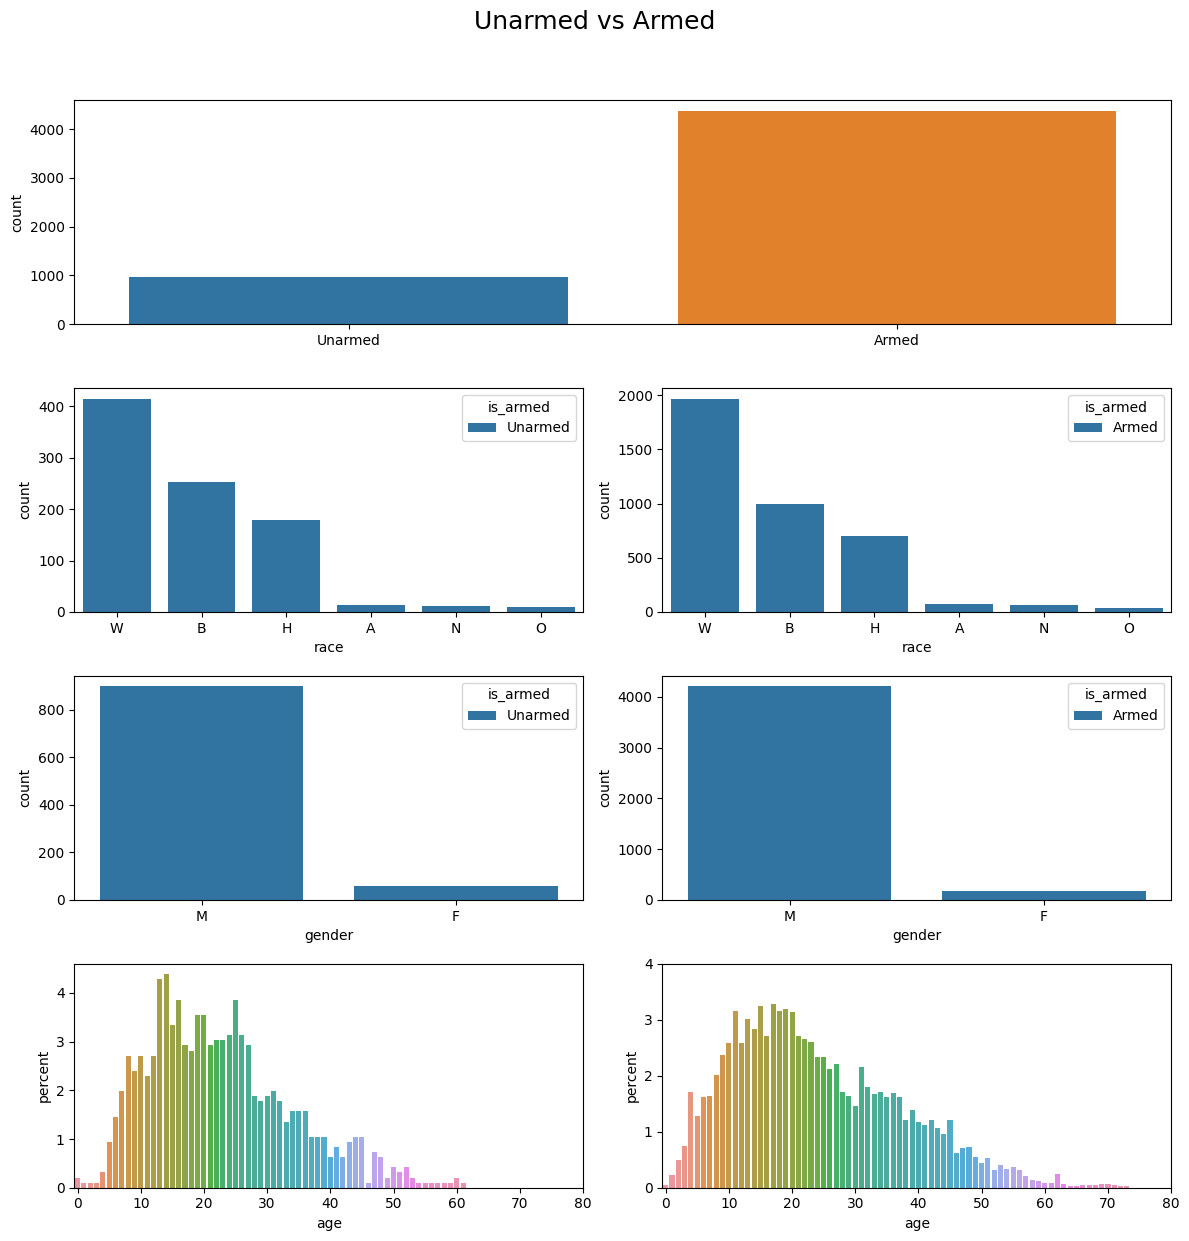

In [ ]:
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3, 1])

fig.suptitle('Unarmed vs Armed', y=1.03, fontsize=18)

# Unarmed vs Armed
sns.countplot(x='is_armed', data=data, order=['Unarmed', 'Armed'], ax=ax0)
ax0.set_xlabel('')

# Race
sns.countplot(x='race', ax=ax1, data=unarmed_data,
              order=['W', 'B', 'H', 'A', 'N', 'O'], hue='is_armed')
sns.countplot(x='race', ax=ax2, data=armed_data,
              order=['W', 'B', 'H', 'A', 'N', 'O'], hue='is_armed')
for ax in [ax1, ax2]:
    ax.set_ylabel('count')
    ax.legend(title='is_armed', loc='upper right')  # Add a legend to differentiate 'Unarmed' and 'Armed'

# Gender
sns.countplot(x='gender', ax=ax3, data=unarmed_data,
              hue='is_armed', order=['M', 'F'])
sns.countplot(x='gender', ax=ax4, data=armed_data,
              hue='is_armed', order=['M', 'F'])
for ax in [ax3, ax4]:
    ax.set_ylabel('count')
    ax.legend(title='is_armed', loc='upper right')  # Add a legend to differentiate 'Unarmed' and 'Armed'


# Age
sns.barplot(x='age', y='age', orient='v', ax=ax5, data=unarmed_data,
            estimator=lambda x: len(x) / len(unarmed_data) * 100)
sns.barplot(x='age', y='age', orient='v', ax=ax6, data=armed_data,
            estimator=lambda x: len(x) / len(armed_data) * 100)
for ax in [ax5, ax6]:
    ax.set_ylabel('percent')
    ax.set_xticks(range(0, 90, 10))
    ax.set_xticklabels(range(0, 90, 10))
    ax.set_yticks(range(0, 5))
    ax.set_yticklabels(range(0, 5))

plt.tight_layout()
plt.show()

We can go even further into this and perform a statistic test to see whether some of these feature distributions are the same for unarmed and armed statistics. We will try this with race, to see whether there is a difference in the distribution of races for police shooting armed victims and unarmed victims. To do this, we will use the chi-squared test with a significance level of 5%. Therefore, if we get a p value below 0.05 then we can reject the null hypothesis and say that there is some difference between the distribution of races of armed and unarmed victims.

In [ ]:
from scipy.stats import chi2_contingency

unarmed_vals = unarmed_data.groupby('race').count()['id'].reset_index().sort_values('race')['id'].values
armed_vals = armed_data.groupby('race').count()['id'].reset_index().sort_values('race')['id'].values
chi_table = np.array([unarmed_vals, armed_vals])
chi_test = chi2_contingency(chi_table)
print('Chi Squared Statistic:', chi_test[0])
print('Degrees of Freedom:   ', chi_test[2])
print('P Value:              ', chi_test[1])
print('SIGNIFICANCE' if chi_test[1] < 0.05 else 'NO SIGNIFICANCE')

Chi Squared Statistic: 8.157362380567182
Degrees of Freedom:    5
P Value:               0.1477736655365786
NO SIGNIFICANCE


We can conclude that there is no significance for race.

We will not attempt this test with gender as we can see from the previous charts that they are very similar. However, there does appear to be some differences in age so we will also try this test with age.

In [ ]:
unarmed_ages = unarmed_data.groupby('age').count()['id'].reset_index().sort_values('age')
armed_ages = armed_data.groupby('age').count()['id'].reset_index().sort_values('age')

unarmed_vals = []
armed_vals = []
for age in range(100):
    zeros = 0
    try:
        unarmed_vals.append(unarmed_ages[unarmed_ages['age'] == age]['id'].reset_index(drop=True)[0])
    except:
        unarmed_vals.append(0)
        zeros += 1
    try:
        armed_vals.append(armed_ages[armed_ages['age'] == age]['id'].reset_index(drop=True)[0])
    except:
        armed_vals.append(0)
        zeros += 1
    if zeros > 1:
        unarmed_vals.pop()
        armed_vals.pop()
chi_table = np.array([unarmed_vals, armed_vals])
chi_test = chi2_contingency(chi_table)
print('Chi Squared Statistic:', chi_test[0])
print('Degrees of Freedom:   ', chi_test[2])
print('P Value:              ', chi_test[1])
print('SIGNIFICANCE' if chi_test[1] < 0.05 else 'NO SIGNIFICANCE')

Chi Squared Statistic: 132.71579667394118
Degrees of Freedom:    76
P Value:               6.172781876855687e-05
SIGNIFICANCE


We have found that there is a significance for age, meaning that there is a statistical difference in the age distributions of unarmed and armed victims. The only issue we have with this test is that for some of the ages we have a very small sample (less than 5 people for some ages), which chi squared is very sensitive to, meaning that using the test in this case may not be perfect.

# Who Are The Unarmed Victims?
There are 318 victims listed in this dataset that are unarmed. To visually display the names of these victims we will create a wordcloud of their names. Firstly, we must obtain an image mask - in this case we will use a map of the USA (the mask must be binarised for this to work, we also perform that after obtaining the image). We then need to create a dictionary of the names, with the frequency that they appear (each name will appear once so we can set the frequencies to 1 each time). Finally, we use the wordcloud package to create a wordcloud. The results are below.

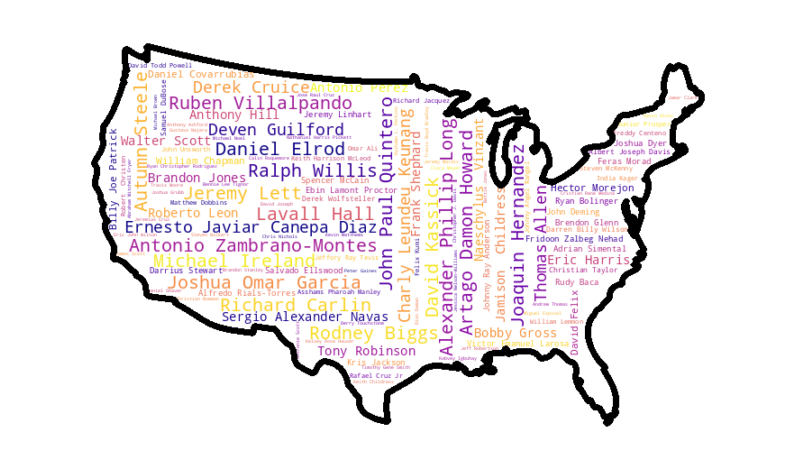

In [ ]:
from wordcloud import WordCloud
import requests
from PIL import Image
from io import BytesIO

# Obtain image mask
response = requests.get('https://www.kindpng.com/picc/m/672-6720557_us-outline-usa-map-vector-png-transparent-png.png')
usa_mask = np.array(Image.open(BytesIO(response.content)))[:,:,2]
usa_mask = 255 * (usa_mask > 50)

# Get a dict of unarmed names
unarmed_names = data[data['armed'] == 'unarmed']['name'].values
unarmed_names_dict = dict()
for name in unarmed_names:
    unarmed_names_dict[name] = 1

# Create wordcloud
wc = WordCloud(background_color='white', mask=usa_mask, max_words=1000,
               contour_width=10, max_font_size=20, colormap='plasma').generate_from_frequencies(unarmed_names_dict)

# Display wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<br>
## FINDINGS - SUMMARY

* Blacks are 3 times more likely to become victims of police shootings than Whites.
* The average age of Black and Hispanic victims is lower (31 and 33 respectively) than that of White victims (40).
* California is the state with the most fatal police shootings, and Los Angeles is the most dangerous city.
* The most common way of being armed is by gun.

**Critical afterthought**

The data has some obvious shortcomings. For instance, it only goes 2.5 years back in time. It would be interesting to look at data from before this period as well, but as previously mentioned, such data is hard to find. Furthermore, this data doesn't track death from other means than by shooting (such as death in police custody and other means of death).
Judging by the accuracy score of the three algorithms, the features don't do very well in explaining the target class.